In [1]:
# auto reload modules 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/git')

import numpy as np
import os
import glob
import pandas as pd 
import h5py
import pickle
import cv2 as cv

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.path import Path

import scipy.signal as signal
from scipy.interpolate import LinearNDInterpolator, griddata
from datetime import datetime,timedelta
import pytz

from shapely.geometry import Polygon, Point
from scipy.spatial import ConvexHull

import icewave.tools.matlab2python as mat2py
import icewave.sebastien.set_graphs as set_graphs
import icewave.drone.drone_projection as dp
import icewave.tools.matlab_colormaps as matcmaps
import icewave.tools.Fourier_tools as FT
import icewave.tools.rw_data as rw 

# PARULA COLORMAP 
parula_map = matcmaps.parula()

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

Windows
Babasse


### Function section 

In [2]:
#%% FUNCTION SECTION

def transpose_PIVmat_fields(m):
    """ Change dimensions of different fields computed using PIVlab """
    key_fields = ['Vx','Vy','Vz','X','Y']

    for key in key_fields:
        m[key] = np.transpose(m[key])
        
    return m

#--------------------------------------------------------------------------------------

def synchronize_with_all_drones(m,istart = 0, iend = -1):
    """ Keep only data that is common to all drones """
    
    fields_with_time = ['Vx','Vy','Vz']
    for key in fields_with_time:
        m[key] = m[key][:,:,istart:iend]
    
    m['t'] = m['t'][istart:iend]
    
    return m


#---------------------------------------------------------------------------------------

def points_to_polygon(points):
    """Create a convex hull polygon from a set of points."""
    points = np.array(points)
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    return Polygon(hull_points)

#---------------------------------------------------------------------------------------

def interpolate_field(known_points,field,grid_x,grid_y,mask):
    """ Interpolate a 2D field, known on a set of coordinates known_points, onto coordinates grid_x,grid_y 
    Inputs : """

    gridded_field = griddata(known_points, field.ravel(), 
                              (grid_x,grid_y),method = 'linear')
    gridded_field = griddata(known_points, field.ravel(), 
                              (grid_x,grid_y),method = 'linear')
    
    # keep only points within the common area
    gridded_field[~mask] = np.nan
    gridded_field[~mask] = np.nan

    return gridded_field

#---------------------------------------------------------------------------------------


def get_zstar(H,alpha,Y):
    """ Compute distance z_star in the projection geometry (distance between the camera and the plane 
    orthogonal to optical axis and crossing the observed point on the ice, which coordinate is Y in the reference 
    frame work of the drone) 
    
    Inputs : - H, drone height in meter
             - alpha, angle with respect to horizontal (in rad)
             - Y array like or float """
             
    z_star = H/np.sin(alpha) + np.cos(alpha)*Y
    return z_star

#---------------------------------------------------------------------------------------------------------------------------
# comute system coefficients 
def compute_coeffs(H,alpha,theta,focale,X,Y):
    """ Compute matrix coefficients for velocity field inversion
    Inputs : - H, float, drone height in meter
             - alpha, float, camera pitch angle with respect to the horizontal, in rad 
             - theta, float, yaw angle between the coordinate system (X,Y) that is projected and the coordinate system 
             of reference chosen to be projected. theta is taken clockwise and expressed in rad
             - focale, float, camera focal length
             - X,Y, coordinates X,Y in the coordinates system which is projected """

    if np.logical_or(alpha <0, alpha > np.pi/2):
        raise Exception("alpha does not belongs to [0,pi/2]")
    
    z_star = get_zstar(H, alpha, Y)
    
    a = (np.cos(theta) + np.sin(theta)*np.cos(alpha)*X/z_star)* focale / z_star
    b = (np.sin(theta) -np.cos(theta)*np.cos(alpha)*X/z_star)* focale / z_star
    c = np.sin(alpha)*X*focale/z_star**2
    d = (-np.sin(theta)*np.sin(alpha) + np.sin(theta)*np.cos(alpha)*Y*np.sin(alpha)/z_star)* focale / z_star
    e = (np.cos(theta) * np.sin(alpha) - np.cos(theta) * np.cos(alpha)*np.sin(alpha)*Y/z_star)*focale/z_star
    f = (np.cos(alpha) + np.sin(alpha)*np.sin(alpha)*Y/z_star)*focale/z_star

    coeffs = np.array((a,b,c,d,e,f))
    return coeffs

#-----------------------------------------------------------------------------------------------------------------------------

def create_matrix(param_ref,param_proj,grid_x,grid_y,grid_x_proj,grid_y_proj):
    """ Create matrix 4 x 3 for each position. This matrix needs to be solved in least square method to compute the real field 
    components. 
    Inputs : - param_ref , dictionnary, drone parameter of reference drone
             - param_proj, dictionnary, drone parameter of projected drone
             - grid_x,grid_y, array like shape [ny,nx], X,Y meshgrid coordinates in the reference coordinate system
             - grid_x_proj,y_grid_proj, array like, shape [ny,nx], X_proj, Y_proj meshgrid coordinates. Correspond
             to grid_x,grid_y coordinates projected in the projected coordinate system. 
    Output : M, numpy array,shape [4,3,ny,nx], M[:,:,i,j] contains the matrix to be inverted at position grid_x[i,j],grid_y[i,j]
    in order to compute the field (ux,uy,uz) at this specific position. """

    theta_ref = 0
    theta_proj = (param_ref['azimuth'] - param_proj['azimuth'])*np.pi/180

    coeffs_ref = compute_coeffs(param_ref['h'],param_ref['alpha_0'],theta_ref,param_ref['focale'],
                             grid_x,grid_y)
    coeffs_proj = compute_coeffs(param_proj['h'],param_proj['alpha_0'],theta_proj,param_proj['focale'],
                             grid_x_proj,grid_y_proj)

    # define matrix
    M = np.array([
    [coeffs_ref[0,:,:], coeffs_ref[1,:,:], coeffs_ref[2,:,:]],
    [coeffs_ref[3,:,:], coeffs_ref[4,:,:], coeffs_ref[5,:,:]],
    [coeffs_proj[0,:,:], coeffs_proj[1,:,:], coeffs_proj[2,:,:]],
    [coeffs_proj[3,:,:], coeffs_proj[4,:,:], coeffs_proj[5,:,:]]   
    ])

    return M



### Load PIV data

In [3]:
date = '0211'
path2data = f'E:/Rimouski_2024/Data/{date}/Drones/'
drones = ['bernache','mesange']
data = {}
for i in range(len(drones)):
    filelist = glob.glob(f'{path2data}*{drones[i]}/matData/*scaled.mat')    
    file2load = filelist[0]
    with h5py.File(file2load, 'r') as fmat:
        print('Top-level keys : ', list(fmat.keys()))
    
        data[drones[i]] = mat2py.mat_to_dict(fmat['m'],fmat['m'])

Top-level keys :  ['#refs#', '#subsystem#', 'm']
Top-level keys :  ['#refs#', '#subsystem#', 'm']


### Load synchronization file and procruste analysis

In [4]:
#%% Load synchro file 
filename = f'{path2data}synchro_3drones.pkl'

with open(filename,'rb') as pf:
   synchro = pickle.load(pf)
   
# Synchronize data and structure them
drone_keys = ['bernache','mesange']
for key in drone_keys :
    data[key] = transpose_PIVmat_fields(data[key])
    istart = synchro[key]
    data[key] = synchronize_with_all_drones(data[key],istart = istart)
    
#%% Load all procruste operations 
procruste_file = f'{path2data}procruste_operation_i0_520_Nbframes_4000_any_drones.pkl'

with open(procruste_file,'rb') as pf:
    all_op = pickle.load(pf)

# keep the given set of procruste operations 
ref_drone = 'mesange' # drone chosen as reference
projected_drone = 'bernache'

# get drone GPS position and orientation 
file2parameters = f'{path2data}parameters_3drones.pkl'
with open(file2parameters,'rb') as pf :
    param = pickle.load(pf)

In [84]:
synchro

{'fulmar': 0, 'mesange': 520, 'bernache': 520}

### Load buoys positions

In [48]:
file2load = f'{path2data}structure_buoys_tracking_3drones.pkl'
with open(file2load,'rb') as pf:
    Z = pickle.load(pf)

# Create a colormap for each drone 

maps = {'fulmar':'Blues','bernache':'Oranges','mesange':'Greens'}
maps_drone = {}
for key_drone in maps.keys():
    maps_drone[key_drone] = {}
    full_map = mpl.colormaps[maps[key_drone]].resampled(256)
    new_map = mcolors.ListedColormap(full_map(np.linspace(0.2,1,256)))
    cnorm = mcolors.Normalize(vmin = 0, vmax = 5)
    cnorm_time = mcolors.Normalize(vmin = 0, vmax = Z[key_drone]['t'].max())
    maps_drone[key_drone]['new_map'] = new_map
    maps_drone[key_drone]['cnorm'] = cnorm
    maps_drone[key_drone]['cnorm_time'] = cnorm_time

### Apply procruste operations to bernache Vz wave field (version of 03/2025)

In [6]:
Vz = data[projected_drone]['Vz']
Vz_ref = data[ref_drone]['Vz']
X_ref = data[ref_drone]['X']
Y_ref = data[ref_drone]['Y']

key_procruste = f'{projected_drone}_2_{ref_drone}'
procruste_op = all_op[key_procruste]

# select frame 
frame = 616

# get procruste operations
R = procruste_op['rot'][:,:,frame]
translation = procruste_op['translat'][:,frame]
scaling = procruste_op['scaling'][frame]

# get X,Y positions of the whole field
X = data[projected_drone]['X']
Y = data[projected_drone]['Y']

# compute X,Y in the new reference frame 
X_proj,Y_proj = dp.change_XY_reference_system(X, Y, param[projected_drone], param[ref_drone], R, translation, scaling)


### Superpose velocity fields

In [88]:
Vz_ref.shape

(237, 132, 3475)

(-25.0, 50.0)

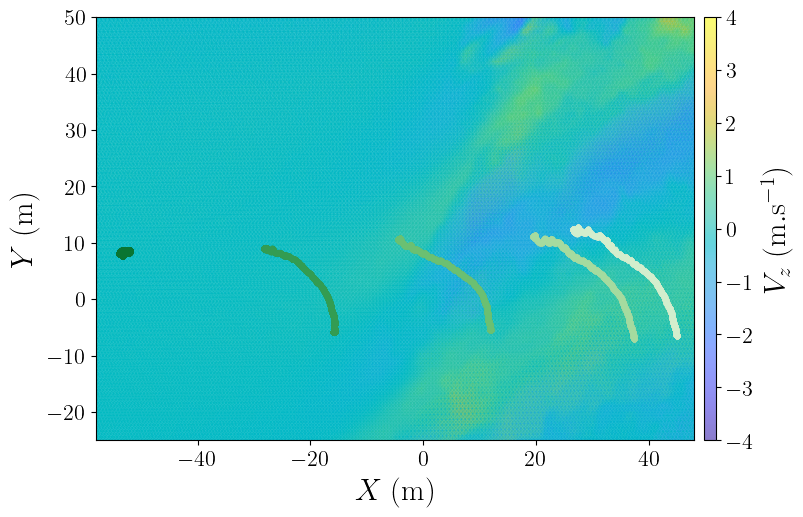

In [51]:
Nb_frames = 4000
i0 = synchro[ref_drone]
Nb_buoys = 6

set_graphs.set_matplotlib_param('single')
fig, ax = plt.subplots()
c = ax.pcolormesh(X_ref,Y_ref,Vz_ref[:,:,frame],shading = 'gouraud', cmap = parula_map,vmin = -4, vmax = 4,
                  alpha = 0.6)
c.set_rasterized(True)

cproj = ax.pcolormesh(X_proj,Y_proj,Vz[:,:,frame],shading = 'gouraud', cmap = parula_map,vmin = -4, vmax = 4,
                      alpha = 0.3)
cproj.set_rasterized(True)

for i in range(Nb_buoys):
    current_color = maps_drone[ref_drone]['new_map'](maps_drone[ref_drone]['cnorm'](i))
    ax.plot(Z[ref_drone]['real'][i,0,:],Z[ref_drone]['real'][i,1,:],'.',color = current_color) 
        
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(c,cax = cax)
cbar.set_label(r'$V_z \; \mathrm{(m.s^{-1})}$',labelpad = 5)

ax.set_xlabel(r'$X \; \mathrm{(m)}$')
ax.set_ylabel(r'$Y \; \mathrm{(m)}$')

ax.set_aspect(1)
ax.set_xlim([-58,48])
ax.set_ylim([-25,50])

### Keep only coordinates common to both drone

In [8]:
projected_points = np.array([X_proj.ravel(),Y_proj.ravel()]).T
ref_points = np.array([X_ref.ravel(),Y_ref.ravel()]).T

# Build polygons from convex hulls
poly_ref = points_to_polygon(ref_points)
poly_proj = points_to_polygon(projected_points)

# Compute intersection polygon
intersection = poly_ref.intersection(poly_proj)

NameError: name 'points_in_common_ref' is not defined

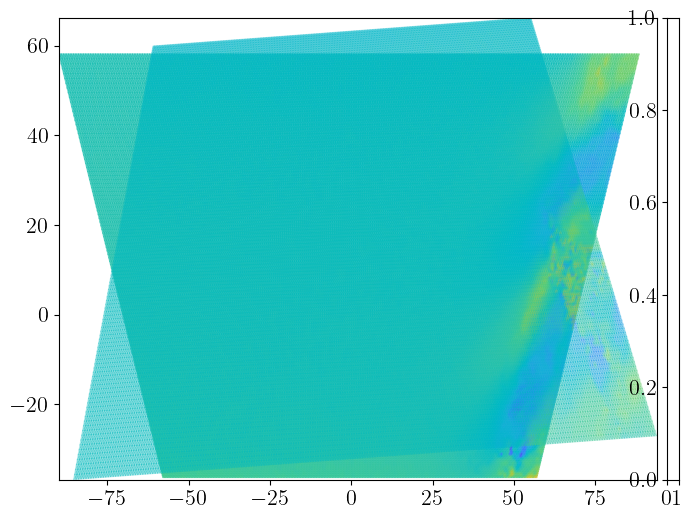

In [12]:
set_graphs.set_matplotlib_param('single')
fig, ax = plt.subplots()
c = ax.pcolormesh(X_ref,Y_ref,Vz_ref[:,:,i],shading = 'gouraud', cmap = parula_map,vmin = -4, vmax = 4,
                  alpha = 0.6)
c.set_rasterized(True)

cproj = ax.pcolormesh(X_proj,Y_proj,Vz[:,:,i],shading = 'gouraud', cmap = parula_map,vmin = -4, vmax = 4,
                      alpha = 0.3)
cproj.set_rasterized(True)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

ax.plot(points_in_common_ref[:,0],points_in_common_ref[:,1],'.',color = 'tab:blue')
ax.plot(points_in_common_proj[:,0],points_in_common_proj[:,1],'.',color = 'tab:red')

cbar = plt.colorbar(c,cax = cax)
cbar.set_label(r'$V_z \; \mathrm{(m.s^{-1})}$',labelpad = 5)
ax.set_xlabel(r'$X \; \mathrm{(m)}$')
ax.set_ylabel(r'$Y \; \mathrm{(m)}$')

ax.set_aspect(1)
ax.set_xlim([-100,110])
ax.set_ylim([-60,80])

# Compute velocity field on a rectangular grid

### Build a grid using intersection polygons

In [78]:
data['mesange']['Vx'].shape

(3475, 132, 0)

In [9]:
artificial_facq_x = 1/0.8 # artificial spatial frequency in box/meter
minx, miny, maxx, maxy = intersection.bounds
grid_x, grid_y = np.meshgrid(
    np.linspace(minx, maxx, int((maxx - minx)*artificial_facq_x)),   # resolution: increase/decrease 
    np.linspace(miny, maxy, int((maxy - miny)*artificial_facq_x))
)

# Mask grid points outside intersection
mask = np.array([Point(x, y).within(intersection) 
                 for x, y in zip(grid_x.ravel(), grid_y.ravel())])
mask = mask.reshape(grid_x.shape)

# Interpolate set points of reference 

gridded_Vx_ref = griddata(np.array(ref_points), data[ref_drone]['Vx'][:,:,frame].ravel(), 
                          (grid_x,grid_y),method = 'linear')
gridded_Vy_ref = griddata(np.array(ref_points), data[ref_drone]['Vy'][:,:,frame].ravel(), 
                          (grid_x,grid_y),method = 'linear')

# keep only points within the common area
gridded_Vx_ref[~mask] = np.nan
gridded_Vy_ref[~mask] = np.nan

gridded_Vx_proj = griddata(np.array(projected_points),data[projected_drone]['Vx'][:,:,frame].ravel(),
                           (grid_x,grid_y),method = 'linear')
gridded_Vy_proj = griddata(np.array(projected_points), data[projected_drone]['Vy'][:,:,frame].ravel(), 
                          (grid_x,grid_y),method = 'linear')

gridded_Vx_proj[~mask] = np.nan
gridded_Vy_proj[~mask] = np.nan

In [17]:
print(minx,miny,maxx,maxy)

-73.62913294366503 -35.1464088892779 75.27989893871661 58.18198769641651


Text(0.5, 1.0, '$V_y^{\\mathrm{proj}}$')

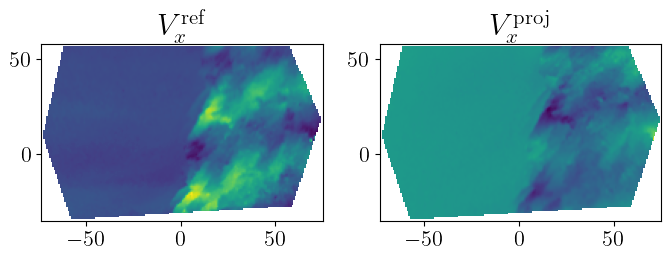

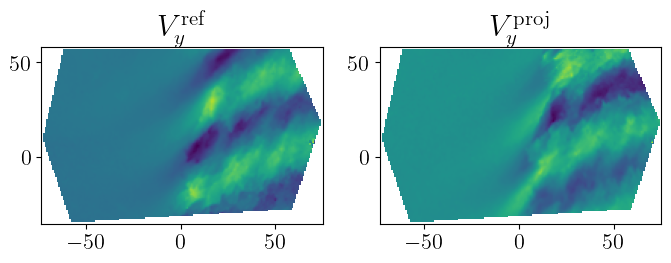

In [10]:
fig, axs = plt.subplots(nrows = 1,ncols = 2)
axs[0].imshow(gridded_Vx_ref,extent = (minx,maxx,miny,maxy),origin = 'lower')
axs[0].set_title('$V_x^{\mathrm{ref}}$')
axs[1].imshow(gridded_Vx_proj,extent = (minx,maxx,miny,maxy),origin = 'lower')
axs[1].set_title('$V_x^{\mathrm{proj}}$')

fig, axs = plt.subplots(nrows = 1,ncols = 2)
axs[0].imshow(gridded_Vy_ref,extent = (minx,maxx,miny,maxy),origin = 'lower')
axs[0].set_title('$V_y^{\mathrm{ref}}$')
axs[1].imshow(gridded_Vy_proj,extent = (minx,maxx,miny,maxy),origin = 'lower')
axs[1].set_title('$V_y^{\mathrm{proj}}$')

### Compute coordinates of the grid in the framework of the projected drone

In [12]:
key_procruste = f'{ref_drone}_2_{projected_drone}'
print(key_procruste)
procruste_op = all_op[key_procruste]

# get procruste operations
R = procruste_op['rot'][:,:,frame]
translation = procruste_op['translat'][:,frame]
scaling = procruste_op['scaling'][frame]

# compute X,Y in the new reference frame 
grid_proj_back_X,grid_proj_back_Y = dp.change_XY_reference_system(grid_x, grid_y, 
                                                        param[ref_drone], param[projected_drone], 
                                                        R, translation, scaling)

mesange_2_bernache


Text(0.5, 1.0, 'bernache')

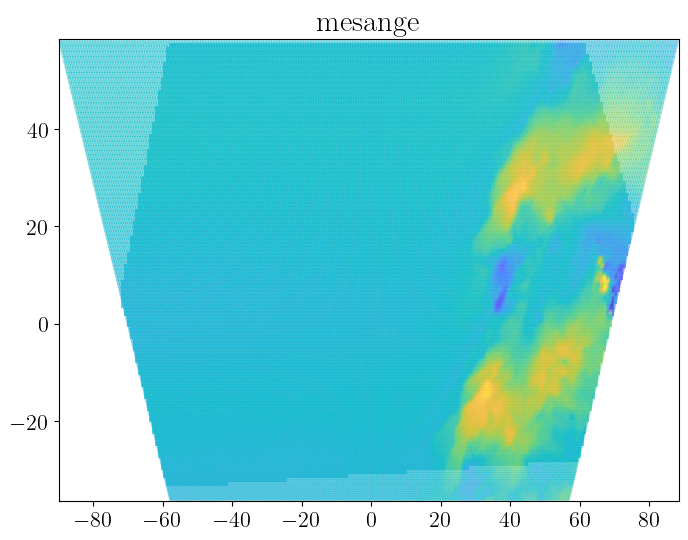

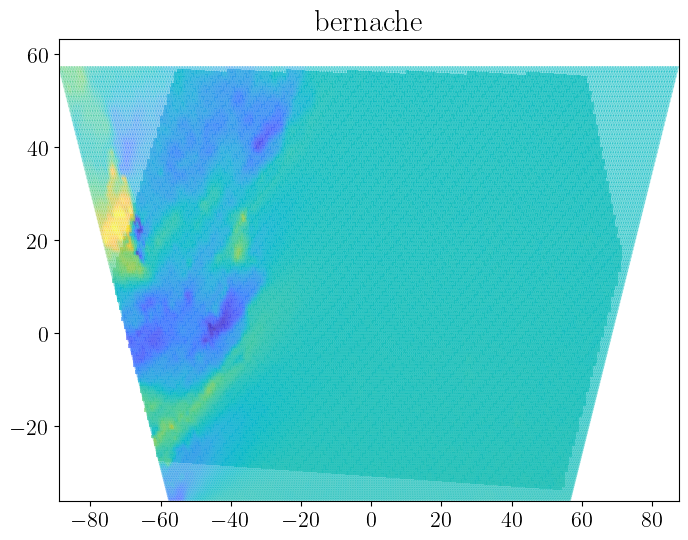

In [60]:
fig, ax = plt.subplots()
c = ax.pcolormesh(grid_x,grid_y,gridded_Vx_ref, cmap = parula_map, alpha = 0.6)
c.set_rasterized(True)

c = ax.pcolormesh(data[ref_drone]['X'],data[ref_drone]['Y'],data[ref_drone]['Vx'][:,:,frame],
              shading = 'gouraud',cmap = parula_map,alpha = 0.3)
c.set_rasterized(True)
ax.set_title(f'{ref_drone}')

# bernache 
fig, ax = plt.subplots()
c = ax.pcolormesh(grid_proj_back_X,grid_proj_back_Y,gridded_Vx_proj, cmap = parula_map, alpha = 0.6)
c.set_rasterized(True)

c = ax.pcolormesh(data[projected_drone]['X'],data[projected_drone]['Y'],data[projected_drone]['Vx'][:,:,frame],
              shading = 'gouraud',cmap = parula_map,alpha = 0.3)
c.set_rasterized(True)

ax.set_title(f'{projected_drone}')

### Compute matrix coefficient

In [13]:
theta_ref = 0
theta_proj = (param[ref_drone]['azimuth']-param[projected_drone]['azimuth'])*np.pi/180
#--------------------------
# ref_drone : mesange
#--------------------------

coeffs_ref = compute_coeffs(param[ref_drone]['h'],param[ref_drone]['alpha_0'],theta_ref,param[ref_drone]['focale'],
                             grid_x,grid_y)

#--------------------------
# projected_drone : bernache
#--------------------------

coeffs_proj = compute_coeffs(param[projected_drone]['h'],param[projected_drone]['alpha_0'],theta_proj,param[projected_drone]['focale'],
                             grid_proj_back_X,grid_proj_back_Y)

### Create matrix M (4x3) for all positions of the grid

In [14]:
M = np.array([
    [coeffs_ref[0,:,:], coeffs_ref[1,:,:], coeffs_ref[2,:,:]],
    [coeffs_ref[3,:,:], coeffs_ref[4,:,:], coeffs_ref[5,:,:]],
    [coeffs_proj[0,:,:], coeffs_proj[1,:,:], coeffs_proj[2,:,:]],
    [coeffs_proj[3,:,:], coeffs_proj[4,:,:], coeffs_proj[5,:,:]]   
])

# member b 
b = np.array([
    gridded_Vx_ref,
    gridded_Vy_ref,
    gridded_Vx_proj,
    gridded_Vy_proj
])

In [127]:
b.shape

(4, 117, 186)

### Create matrix M(3x3) for all positions of the grid

In [32]:
# M contains matrix 3x3 for all points of the grid 
M = np.array([
    [(coeffs_ref[0,:,:] + coeffs_proj[0,:,:])*0.5, (coeffs_ref[1,:,:] + coeffs_proj[1,:,:])*0.5, 
     (coeffs_ref[2,:,:] + coeffs_proj[2,:,:])*0.5 ], # coeffs of equation ((1) + (3))/2
    [coeffs_ref[3,:,:], coeffs_ref[4,:,:], coeffs_ref[5,:,:]], # coeffs of equation (2)
    [coeffs_proj[3,:,:], coeffs_proj[4,:,:],coeffs_proj[5,:,:]] # coeffs of equation (4)
    ])


# member b 
b = np.array([
    0.5*(gridded_Vx_ref + gridded_Vx_proj),
    gridded_Vy_ref,
    gridded_Vy_proj,
    ])

Text(0.5, 1.0, 'Reference')

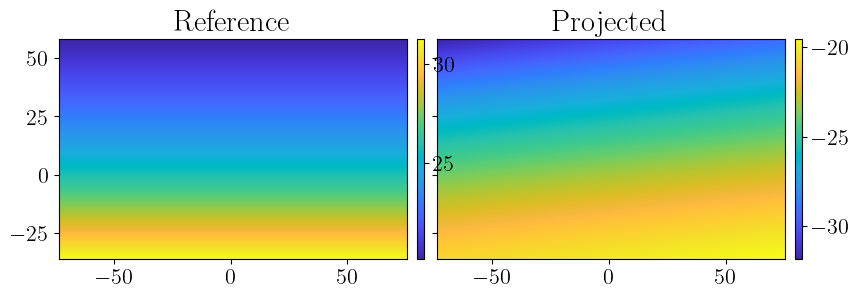

In [55]:
fig, axs = plt.subplots(ncols = 2, sharey = True, layout = 'constrained')
imsh = axs[0].imshow(coeffs_ref[0,:,:],extent = (minx,maxx,miny,maxy),origin = 'lower',cmap = parula_map)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)

imsh = axs[1].imshow(coeffs_proj[0,:,:],extent = (minx,maxx,miny,maxy),origin = 'lower',cmap = parula_map)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
axs[1].set_title(r'Projected')
axs[0].set_title(r'Reference')

In [43]:
coeffs_proj[0,:,:]

array([[-20.70739508, -20.70082665, -20.69426179, ..., -19.56217315,
        -19.55621507, -19.5502601 ],
       [-20.76986108, -20.76325308, -20.75664869, ..., -19.61790386,
        -19.6119116 , -19.60592249],
       [-20.83270507, -20.82605714, -20.81941285, ..., -19.67395296,
        -19.66792623, -19.66190267],
       ...,
       [-31.51083744, -31.4956747 , -31.48052443, ..., -28.93045838,
        -28.91736162, -28.90427503],
       [-31.65570268, -31.64040084, -31.62511165, ..., -29.05248574,
        -29.03927738, -29.02607934],
       [-31.80190589, -31.78646302, -31.77103298, ..., -29.17554639,
        -29.16222501, -29.14891408]])

### Solve linear system

In [15]:
solutions = np.zeros((3,b.shape[1],b.shape[2]))

for i in range(M.shape[2]):
    for j in range(M.shape[3]):
        if ~mask[i,j] :
            solutions[:,i,j] = None

        else :
            sol = np.linalg.lstsq(M[:,:,i,j],b[:,i,j],rcond = None)
            
            solutions[:,i,j] = sol[0]

### Plot resulting field

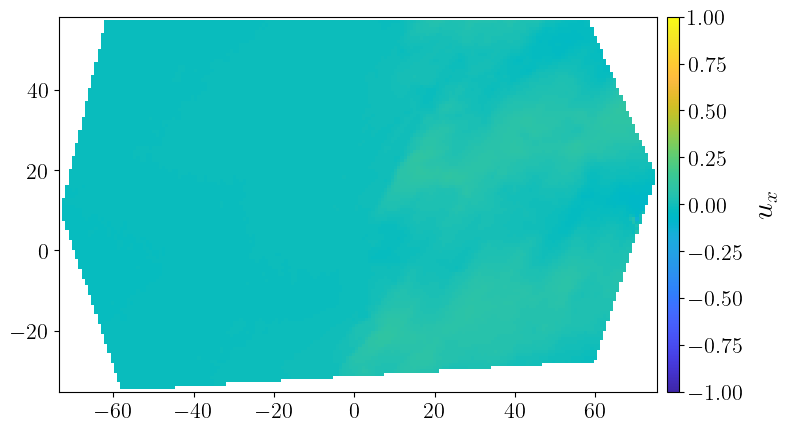

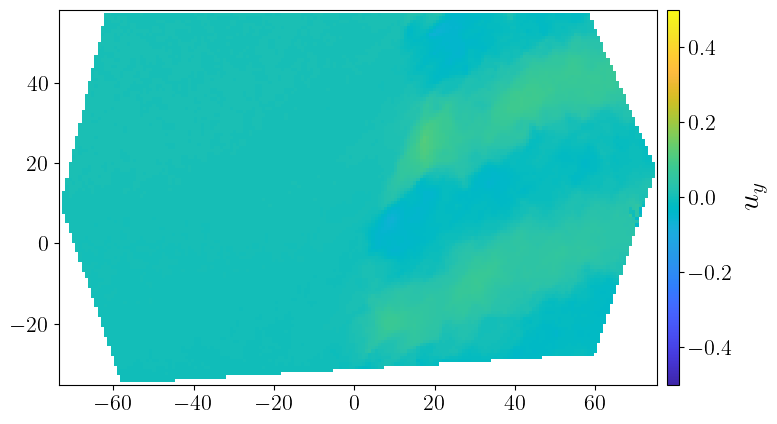

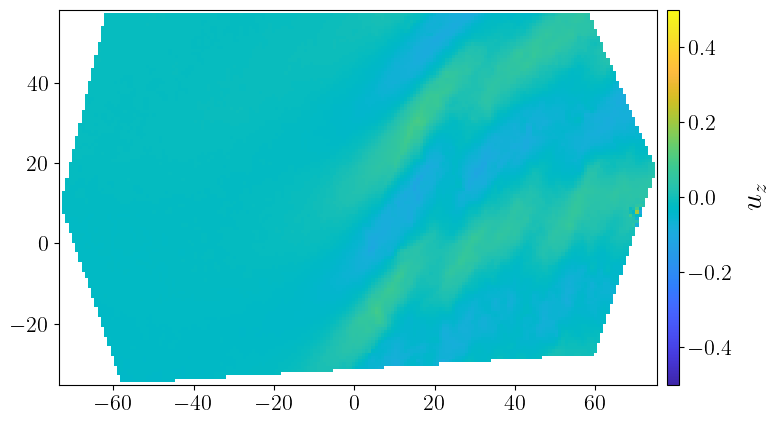

In [16]:
# Plot ux
fig, ax = plt.subplots()
imsh = ax.imshow(solutions[0,:,:],extent = (minx,maxx,miny,maxy),origin = 'lower', cmap = parula_map)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$u_x$')

imsh.set_clim([-1.0,1.0])

# Plot uy
fig, ax = plt.subplots()
imsh = ax.imshow(solutions[1,:,:],extent = (minx,maxx,miny,maxy),origin = 'lower', cmap = parula_map)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$u_y$')

imsh.set_clim([-0.5,0.5])

# Plot uz
fig, ax = plt.subplots()
imsh = ax.imshow(solutions[2,:,:],extent = (minx,maxx,miny,maxy),origin = 'lower', cmap = parula_map)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$u_z$')

imsh.set_clim([-0.5,0.5])

# Generalize previous study for all frames

In [91]:
ref_drone = 'mesange' # drone chosen as reference
projected_drone = 'bernache'
key_procruste = f'{projected_drone}_2_{ref_drone}'
procruste_op = all_op[key_procruste]

### Define grid using minimal values of intersection grid

In [104]:
# get X,Y positions of the whole field
X = data[projected_drone]['X']
Y = data[projected_drone]['Y']

X_ref = data[ref_drone]['X']
Y_ref = data[ref_drone]['Y']
ref_points = np.array([X_ref.ravel(),Y_ref.ravel()]).T

bounds = {}
Nb_frames = data[ref_drone]['Vx'].shape[2]
for frame in range(Nb_frames):
    # get procruste operations
    R = procruste_op['rot'][:,:,frame]
    translation = procruste_op['translat'][:,frame]
    scaling = procruste_op['scaling'][frame]
    
    # compute X,Y in the new reference frame 
    X_proj,Y_proj = dp.change_XY_reference_system(X, Y, param[projected_drone], param[ref_drone], R, translation, scaling)
    projected_points = np.array([X_proj.ravel(),Y_proj.ravel()]).T

    # Build polygons from convex hulls
    poly_ref = points_to_polygon(ref_points)
    poly_proj = points_to_polygon(projected_points)
    
    # Compute intersection polygon
    intersection = poly_ref.intersection(poly_proj)
    if frame == 0:
        minx,miny,maxx,maxy = intersection.bounds
    else:
        current_minx,current_miny, current_maxx, current_maxy = intersection.bounds
        if abs(current_minx) < abs(minx):
            minx = current_minx
        if abs(current_miny) < abs(miny):
            miny = current_miny
        if current_maxx < maxx:
            maxx = current_maxx
        if current_maxy < maxy:
            maxy = current_maxy
    

In [ ]:
print(minx,miny,maxx,maxy)

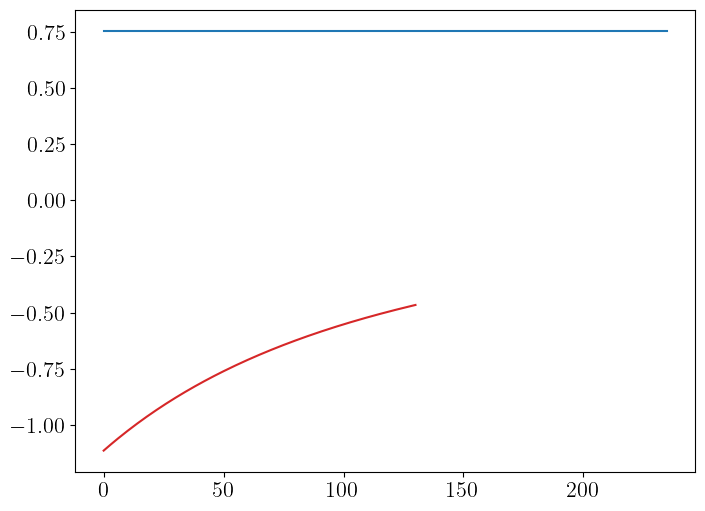

In [35]:
fig, ax = plt.subplots()
ax.plot(np.diff(X_ref[:,0]),color = 'tab:blue')
ax.plot(np.diff(Y_ref[0,:]),color = 'tab:red')

In [52]:
minx = -58
maxx = 48
miny = -25
maxy = 50

In [53]:
artificial_facq_x = 1/0.8 # artificial spatial frequency in box/meter
tmin = data[ref_drone]['t'].min()
tmax = data[ref_drone]['t'].max()
grid_x, grid_y = np.meshgrid(
    np.linspace(minx, maxx, int((maxx - minx)*artificial_facq_x)),  
    np.linspace(miny, maxy, int((maxy - miny)*artificial_facq_x))
)

# Mask grid points outside intersection
mask = np.array([Point(x, y).within(intersection) 
                 for x, y in zip(grid_x.ravel(), grid_y.ravel())])
mask = mask.reshape(grid_x.shape)

In [105]:
print(minx,miny,maxx,maxy)

-72.33443793991802 -33.500658434738185 75.0583880373382 58.18198769641651


### Interpolate $\vec{V}$ for reference drone

In [54]:
frame = 616
# Interpolate velocity fields 
X_ref = data[ref_drone]['X']
Y_ref = data[ref_drone]['Y']
ref_points = np.array([X_ref.ravel(),Y_ref.ravel()]).T

gridded_Vx_ref = interpolate_field(ref_points,data[ref_drone]['Vx'][:,:,frame],grid_x,grid_y,mask) 
gridded_Vy_ref = interpolate_field(ref_points,data[ref_drone]['Vy'][:,:,frame],grid_x,grid_y,mask) 

### Interpolate $\vec{V}$ for projected drone

In [55]:
X = data[projected_drone]['X']
Y = data[projected_drone]['Y']
# get procruste operations
R = procruste_op['rot'][:,:,frame]
translation = procruste_op['translat'][:,frame]
scaling = procruste_op['scaling'][frame]

# compute X,Y in the new reference frame 
X_proj,Y_proj = dp.change_XY_reference_system(X, Y, param[projected_drone], param[ref_drone], R, translation, scaling)
projected_points = np.array([X_proj.ravel(),Y_proj.ravel()]).T

# Interpolate velocity fields 
gridded_Vx_proj = interpolate_field(projected_points,data[projected_drone]['Vx'][:,:,frame],grid_x,grid_y,mask) 
gridded_Vy_proj = interpolate_field(projected_points,data[projected_drone]['Vy'][:,:,frame],grid_x,grid_y,mask) 


In [56]:
key_procruste_back = f'{ref_drone}_2_{projected_drone}'
procruste_op_back = all_op[key_procruste_back]

# get procruste operations
R = procruste_op_back['rot'][:,:,frame]
translation = procruste_op_back['translat'][:,frame]
scaling = procruste_op_back['scaling'][frame]

# compute grid coordinates back to projected drone frame work
grid_proj_back_X,grid_proj_back_Y = dp.change_XY_reference_system(grid_x, grid_y, 
                                                        param[ref_drone], param[projected_drone], 
                                                        R, translation, scaling)

Text(0.5, 1.0, '$V_y^{\\mathrm{proj}}$')

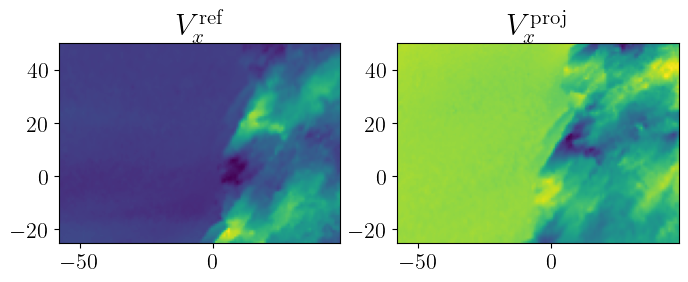

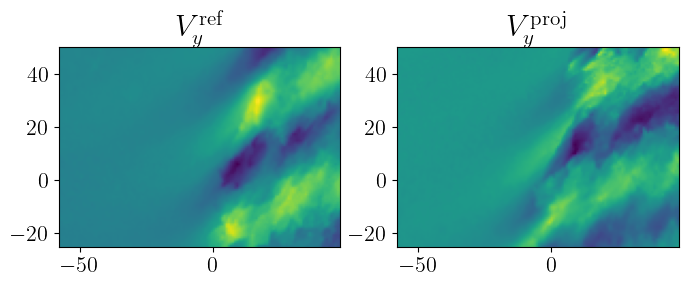

In [57]:
fig, axs = plt.subplots(nrows = 1,ncols = 2)
axs[0].imshow(gridded_Vx_ref,extent = (minx,maxx,miny,maxy),origin = 'lower')
axs[0].set_title('$V_x^{\mathrm{ref}}$')
axs[1].imshow(gridded_Vx_proj,extent = (minx,maxx,miny,maxy),origin = 'lower')
axs[1].set_title('$V_x^{\mathrm{proj}}$')

fig, axs = plt.subplots(nrows = 1,ncols = 2)
axs[0].imshow(gridded_Vy_ref,extent = (minx,maxx,miny,maxy),origin = 'lower')
axs[0].set_title('$V_y^{\mathrm{ref}}$')
axs[1].imshow(gridded_Vy_proj,extent = (minx,maxx,miny,maxy),origin = 'lower')
axs[1].set_title('$V_y^{\mathrm{proj}}$')

### Compute matrix coefficients

In [160]:
grid_x.shape

(106, 145)

In [162]:
M = create_matrix(param[ref_drone],param[projected_drone],grid_x,grid_y,grid_proj_back_X,grid_proj_back_Y)

# member b 
b = np.array([
    gridded_Vx_ref,
    gridded_Vy_ref,
    gridded_Vx_proj,
    gridded_Vy_proj
])

In [151]:
theta_ref = 0
theta_proj = (param[ref_drone]['azimuth'] - param[projected_drone]['azimuth'])*np.pi/180
#--------------------------
# ref_drone : mesange
#--------------------------

coeffs_ref = compute_coeffs(param[ref_drone]['h'],param[ref_drone]['alpha_0'],theta_ref,param[ref_drone]['focale'],
                             grid_x,grid_y)

#--------------------------
# projected_drone : bernache
#--------------------------

coeffs_proj = compute_coeffs(param[projected_drone]['h'],param[projected_drone]['alpha_0'],theta_proj,param[projected_drone]['focale'],
                             grid_proj_back_X,grid_proj_back_Y)


### Build matrix

In [152]:
M = np.array([
    [coeffs_ref[0,:,:], coeffs_ref[1,:,:], coeffs_ref[2,:,:]],
    [coeffs_ref[3,:,:], coeffs_ref[4,:,:], coeffs_ref[5,:,:]],
    [coeffs_proj[0,:,:], coeffs_proj[1,:,:], coeffs_proj[2,:,:]],
    [coeffs_proj[3,:,:], coeffs_proj[4,:,:], coeffs_proj[5,:,:]]   
])

# member b 
b = np.array([
    gridded_Vx_ref,
    gridded_Vy_ref,
    gridded_Vx_proj,
    gridded_Vy_proj
])

### Solve linear system for each position

In [165]:
def solve_linear_system_all_pos(M,b,mask):
    """ Solve linear system for all positions, using 4 equations and least square method. 
    Inputs : - M, numpy array [4,3,ny,nx], matrix containing sub-matrices (4x3) for each position
             - b, numpy array [4,ny,nx] containing apparent velocity field observed on each camera for each position 
             of the studied grid. 
             - mask, array like, boolean array, contains 0 if the corresponding position does not belong to the studied grid
    Output : 
             - solutions, numpy array, [3,ny,nx], contain real velocity field (ux,uy,uz) for all positions of the studied grid
    """

    solutions = np.zeros((3,b.shape[1],b.shape[2]))

    for i in range(M.shape[2]):
        for j in range(M.shape[3]):
            if ~mask[i,j] :
                solutions[:,i,j] = None
    
            else :
                sol = np.linalg.lstsq(M[:,:,i,j],b[:,i,j],rcond = None)
                
                solutions[:,i,j] = sol[0]
    return solutions

solutions = solve_linear_system_all_pos(M,b,mask)
    

### Plot results

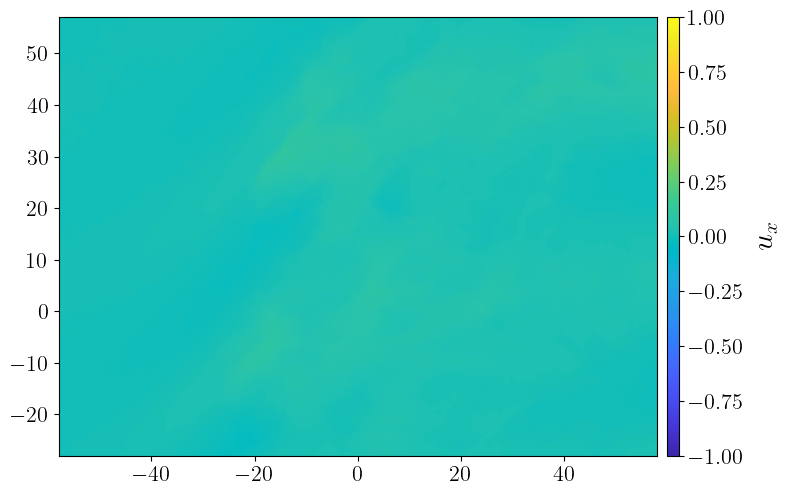

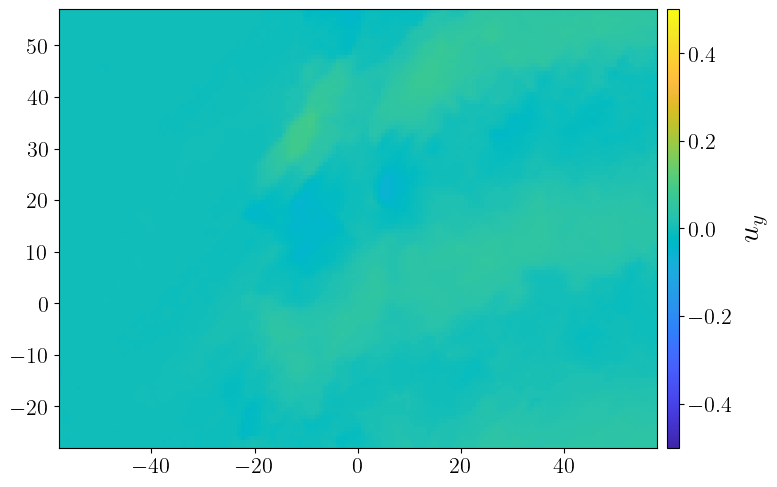

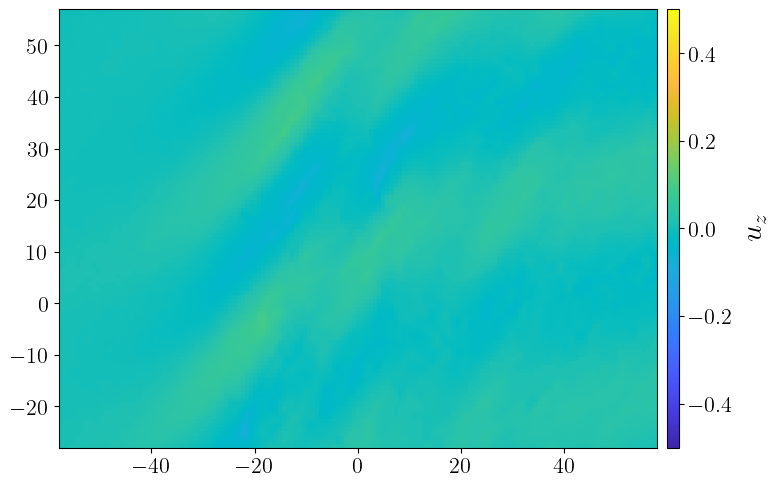

In [166]:
# Plot ux
fig, ax = plt.subplots()
imsh = ax.imshow(solutions[0,:,:],extent = (minx,maxx,miny,maxy),origin = 'lower', cmap = parula_map)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$u_x$')

imsh.set_clim([-1.0,1.0])

# Plot uy
fig, ax = plt.subplots()
imsh = ax.imshow(solutions[1,:,:],extent = (minx,maxx,miny,maxy),origin = 'lower', cmap = parula_map)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$u_y$')

imsh.set_clim([-0.5,0.5])

# Plot uz
fig, ax = plt.subplots()
imsh = ax.imshow(solutions[2,:,:],extent = (minx,maxx,miny,maxy),origin = 'lower', cmap = parula_map)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$u_z$')

imsh.set_clim([-0.5,0.5])